## Epidemiology - Spatial Mapping

The dataset used here contains information on the number of low birth weight babies born in 1999, the number of live births in 1999, and the number of very low birth weight babies born in 1999 for each county in Georgia Health Care District 9. The data was obtianed from _Applied Spatial Statistics for Public Health Data_, by Lance A. Waller and Carol A. Gotway.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import geopandas

In [2]:
# read in and clean data
vlbw = pd.read_csv('vlbw.csv')

# clean column names
vlbw.rename(columns={'No. Live Births':'livebirths', 'No. Low Birth Weight':'lbw', 'No. Very Low Birth Weight':'vlbw'}, inplace=True)

vlbw.head()

,County,livebirths,lbw,vlbw,Easting,Northing
0,Emanuel,308,35,0,380775.664,3606798.382
1,Bulloch,693,64,9,429643.221,3587905.874
2,Effingham,570,36,8,467554.861,3581547.440
3,Candler,151,9,3,398199.760,3581861.311
4,Toombs,454,33,2,375444.918,3558825.264


In [3]:
# check dtypes
print(vlbw.dtypes)

County         object
livebirths      int64
lbw             int64
vlbw            int64
Easting       float64
Northing      float64
dtype: object


### Rates

We start by obtaining the rate of very low birth weights per county by dividing `vlbw` by the number of live births in each county. 

In [4]:
# get rates
vlbw['rate'] = vlbw['vlbw']/vlbw['livebirths']
vlbw.head()

,County,livebirths,lbw,vlbw,Easting,Northing,rate
0,Emanuel,308,35,0,380775.664,3606798.382,0.000000
1,Bulloch,693,64,9,429643.221,3587905.874,0.012987
2,Effingham,570,36,8,467554.861,3581547.440,0.014035
3,Candler,151,9,3,398199.760,3581861.311,0.019868
4,Toombs,454,33,2,375444.918,3558825.264,0.004405


In [5]:
# EDA
print(vlbw['rate'].mean(), vlbw['rate'].std())

0.012769478674647476 0.009242025884770655


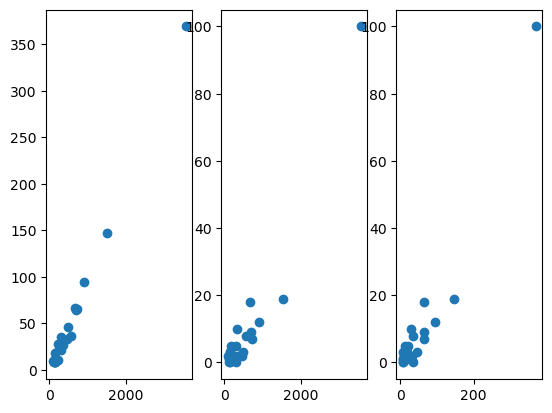

In [6]:
# some plots
fig, ax = plt.subplots(1,3)
ax[0].scatter(vlbw['livebirths'], vlbw['lbw'])
ax[1].scatter(vlbw['livebirths'], vlbw['vlbw'])
ax[2].scatter(vlbw['lbw'], vlbw['vlbw'])

plt.show()

As expected, the above plots all demonstrate a linear trend. Note that these plots use the raw counts rather than the rates; we observe that one county is an outlier in terms of population, hence the need for the rate metric.

### Spatial Mapping

We start the analysis by creating a choropleth map of the very low birth rate by county. While the original dataset does provide $(x,y)$ coordinates of the centroids for each county, we need additional information to plot the areal units themselves. Therefore, an ESRI shapefile containing the boundaries of all Georgia counties is read in and merged with the `vlbw` dataframe. The `Geopandas` package is utilized to create and modify the shapefile and plot the choropleth map.

In [7]:
# read GA counties shapefile
GA = geopandas.read_file('Georgia_Counties/Georgia_Counties.shp')    # this is a GeoDataFrame
GA.rename(columns={'NAME10':'County'}, inplace=True)
# GA.head()
# GA.plot()

In [8]:
# we just need the county name and the areal unit geometry
GA = GA[['County', 'geometry']]
# GA.head()

# merge with the original data (note: GA specified first to ensure that the result is still a geodataframe)
GA_vis = pd.merge(GA, vlbw, on='County', how='inner')

# check
print(len(vlbw), len(GA_vis)) # correct

GA_vis.head()

25 25


,County,geometry,livebirths,lbw,vlbw,Easting,Northing,rate
0,Bryan,"POLYGON ((892447.553 705332.815, 892440.514 70...",370,27,2,454305.848,3544080.578,0.005405
1,Appling,"POLYGON ((565486.255 668648.88, 573969.848 668...",257,23,1,374321.622,3513589.072,0.003891
2,Camden,"POLYGON ((817128.982 271070.211, 817117.658 27...",722,65,7,440181.095,3425482.335,0.009695
3,Glynn,"POLYGON ((846515.606 408004.934, 846531.317 40...",908,95,12,454245.142,3456655.732,0.013216
4,Ware,"POLYGON ((587283.311 471814.259, 587516.569 47...",492,46,3,366888.053,3438399.181,0.006098


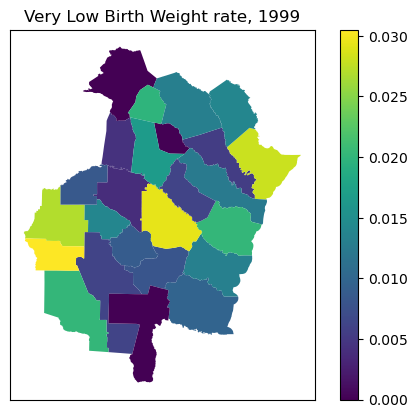

In [9]:
ax = GA_vis.plot(column='rate', legend=True)
ax.set_title('Very Low Birth Weight rate, 1999')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()

The plot above shows the vlbw rates by county. We can observe some hints of spatial patterns in the variability of the rates, but the data is noisy due to the relatively low counts and differences in population sizes. Thus, spatial smoothing is justified in this case to get a better idea of potential spatial patterns which can be investigated with more complex statistical methods. 

### Probability Mapping
Another way to map spatial variations in incidence rates is by calculating the probability of each observed count $y_i$ for each region. Assuming a constant risk hypothesis (i.e., that each region has the same underlying risk), the probability map allows us to index how severely certain regions violate this assumption, which can be an indication of spatial variability.

In [10]:
# probability map

# get overall mean
globalmean = vlbw['rate'].mean()
print(globalmean)

# get expected count for each region
expected = np.array(GA_vis['livebirths'])*globalmean
print(expected)

0.012769478674647476
[ 4.72470711  3.28175602  9.2195636  11.59468664  6.28258351  3.93299943
  1.58341536 45.58703887  1.97926919 19.47345498  5.79734332  1.26417839
  1.62172379  2.91144114  8.5044728   1.82603545  2.0941945   1.92819128
  4.35439223  7.27860284  8.84924872  1.90265232  3.03913592  3.8308436
  2.0941945 ]


In [11]:
# calculate probabilities
from scipy.stats import poisson

actual = np.array(GA_vis['vlbw'])
probs = np.zeros(len(actual))

for i in range(len(actual)):
    k = actual[i]
    mu = expected[i]
    if k <= mu:
        probs[i] = poisson.cdf(k, mu)
    else:
        probs[i] = 1 - poisson.cdf(k, mu)

print(probs)

[1.49835958e-01 1.60832342e-01 2.98816772e-01 3.77787271e-01
 1.27712503e-01 1.95848410e-02 5.30304955e-01 1.05937481e-12
 1.38170176e-01 5.17548333e-01 7.16462483e-02 1.34719311e-01
 1.97557857e-01 4.43320740e-01 1.30510458e-03 2.76360407e-01
 2.02080930e-02 1.30157002e-01 5.28059306e-03 3.07887425e-01
 3.92737851e-01 1.25751634e-01 4.14479430e-01 1.89021744e-01
 3.81110131e-01]


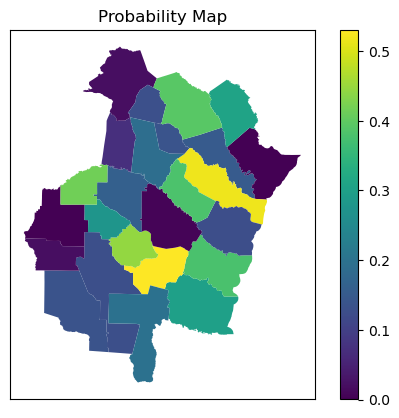

In [12]:
# plot the probability map
GA_vis['prob'] = probs

ax = GA_vis.plot(column='prob', legend=True)
ax.set_title('Probability Map')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()

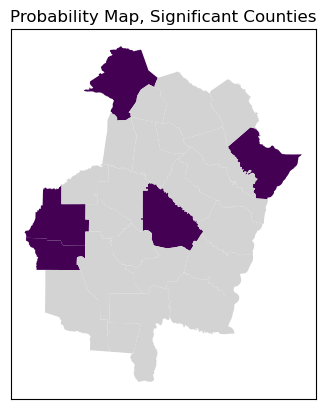

In [13]:
GA_vis['sig'] = 1
sig = GA_vis['prob'] > 0.05

# create a new column whose values are NaN unless p is statistically significant at 0.05
GA_vis.loc[sig, 'sig'] = np.nan

ax = GA_vis.plot(column='sig', missing_kwds={'color': 'lightgrey'})
ax.set_title('Probability Map, Significant Counties')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()

Note that the VLBW rate in Emmanuel county (at top) is significantly _low_, while the rates of the other counties (Coffee, Atkinson, Chatham, and Wayne) are significantly high.

### Smoothing - Empirical Bayes (global)

Here we follow the method laid out in _Applied Spatial Statistics for Public Health Data_. We smooth the rates using a global Bayes estimator of the risk, $\hat{\xi_i}$, which is calculated as a weighted average of the prior estimate, $m_i$, and the observed rate, $r_i$. Namely, we assume a prior distribution of the data:  

$$
Y_i \sim Poisson(n_i \xi_i)
$$

And seek to estimate the parameter $\xi_i$. Utilizing a decision-theoretic approach, the best linear Bayes estimator of $\xi_i$ is derived by minimizing the total squared error loss of the resulting posterior distribution, providing us:  

$$
\begin{align*}
\hat{\xi_i} &= m_i + C_i(r_i - m_i) \\
&= C_i r_i + (1-C_i)m_i \\
\end{align*}
$$

where 

$$
C_i = \frac{\nu_i}{(\nu_i + m_i/n_i)}
$$

is the shrinkage factor, allowing us to borrow strength from both the prior parameter estimate $m_i$ and the crude local estimate $r_i$. The hyperpriors $m_i$ and $\nu_i$ are further estimated from the data using Method of Moments. These are global estimates, given as the weighted local mean and sample variance for the entire study region. In this way, by smoothing the rates we are shrinking each county's rate towards a global mean rate, as opposed to local neighborhood rates.

In [14]:
# estimate prior parameters
# weighted sample mean
mi_est = (np.sum(vlbw['rate']*vlbw['livebirths']))/(np.sum(vlbw['livebirths'])) 

# weighted sample variance
s2 = np.sum(GA_vis['livebirths'] * (GA_vis['rate'] - mi_est)**2)/(np.sum(GA_vis['livebirths']))

rates = np.array(GA_vis['rate'])
counts = np.array(GA_vis['livebirths'])

# shrinkage factor
Ci = np.zeros(len(rates))
for i in range(len(rates)):
    Ci[i] = (s2)/(s2 + (mi_est/counts[i]))

Ehat_i = np.zeros(len(rates))
for i in range(len(rates)):
    Ehat_i[i] = Ci[i]*rates[i] + (1-Ci[i])*mi_est

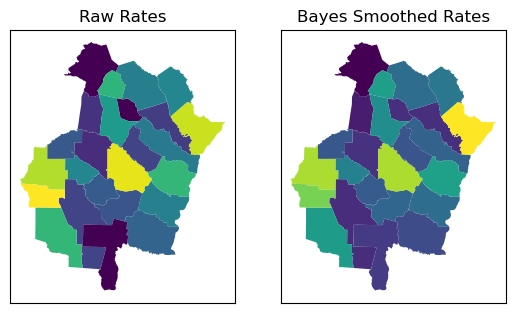

In [15]:
GA_vis['Bayesrate'] = Ehat_i

fig, ax = plt.subplots(1,2)
ax[0].set_xticks([])
ax[1].set_xticks([])
ax[0].set_yticks([])
ax[1].set_yticks([])
ax[0].set_xticklabels([])
ax[1].set_xticklabels([])
ax[0].set_yticklabels([])
ax[1].set_yticklabels([])

GA_vis.plot(ax=ax[0], column='rate')
ax[0].set_title('Raw Rates')

GA_vis.plot(ax=ax[1], column='Bayesrate')
ax[1].set_title('Bayes Smoothed Rates')

plt.show()

### Smoothing - Empirical Bayes (local)

Implement this estimator locally using neighborhoods, rather than estimating a single global parameter. We will use adjacency as our spatial proximity measure.

To do this, we first need to identify the neighbors of each county. The code to do this was obtained [here](https://gis.stackexchange.com/questions/281652/finding-all-neighbors-using-geopandas). It makes use of the GeoPandas `disjoint` operation by creating a list of all counties not disjoint to the current county, and adding the list as a new column in the dataframe.

In [65]:
# determine which counties are neighbors using adjacency
GA_copy = GA_vis.copy()

# add NEIGHBORS column
GA_copy["Neighbors"] = None  

for index, county in GA_copy.iterrows():   

    # get 'not disjoint' countries
    neighbors = GA_copy[~GA_copy.geometry.disjoint(county.geometry)].County.tolist()

    # remove own name of the county from the list
    neighbors = [ name for name in neighbors if county.County != name ]

    # add names of neighbors as NEIGHBORS value
    GA_copy.at[index, "Neighbors"] = ", ".join(neighbors)
   
GA_copy = GA_copy[['County', 'rate', 'geometry', 'livebirths', 'Neighbors']]
GA_copy.head()

,County,rate,geometry,livebirths,Neighbors
0,Bryan,0.005405,"POLYGON ((892447.553 705332.815, 892440.514 70...",370,"Chatham, Evans, Liberty, Effingham, Bulloch"
1,Appling,0.003891,"POLYGON ((565486.255 668648.88, 573969.848 668...",257,"Toombs, Pierce, Bacon, Wayne, Jeff Davis, Tatt..."
2,Camden,0.009695,"POLYGON ((817128.982 271070.211, 817117.658 27...",722,"Glynn, Brantley, Charlton"
3,Glynn,0.013216,"POLYGON ((846515.606 408004.934, 846531.317 40...",908,"Camden, Brantley, Wayne, McIntosh"
4,Ware,0.006098,"POLYGON ((587283.311 471814.259, 587516.569 47...",492,"Brantley, Clinch, Charlton, Pierce, Coffee, Ba..."


In [39]:
# now we need a way to get the weights. This could be done elegantly with an adjacency matrix, but I will first do it
# using loops

# to do this, we will just get subsets of data for each neighbor, and then do the exact operations as before, except on the subset
# instead of the whole dataset

# create list
testlist = GA_copy.iloc[0]['Neighbors'].split(', ')
rates = np.zeros(len(testlist))
livebirths = np.zeros(len(testlist))
for i in range(len(testlist)):
    rates[i] = (GA_copy.loc[GA_copy['County'] == testlist[i], 'rate'].iloc[0])
    livebirths[i] = (GA_copy.loc[GA_copy['County'] == testlist[i], 'livebirths'].iloc[0])

rates

array([0.0280112 , 0.        , 0.01245902, 0.01403509, 0.01298701])

In [56]:
n_i = GA_copy.loc[GA_copy['County'] == 'Bryan', 'livebirths'].iloc[0]
r_i = GA_copy.loc[GA_copy['County'] == 'Bryan', 'rate'].iloc[0]

mi_est = (np.sum(rates*livebirths))/(np.sum(livebirths)) 
s2 = np.sum(livebirths * (rates - mi_est)**2)/(np.sum(livebirths))

# get shrinkage factor
Ci = (s2)/(s2 + (mi_est/n_i))

# get local estimate
Ehat_i = Ci*r_i + (1-Ci)*mi_est

print(Ehat_i)

0.012563250001282902


In [63]:
# subfunction to get rates
def countyestimate(gdf, county, neighbors):

    # get rates and ncounts of all neighbors
    rates = np.zeros(len(neighbors))
    livebirths = np.zeros(len(neighbors))
        
    for i in range(len(neighbors)):
        rates[i] = (gdf.loc[gdf['County'] == neighbors[i], 'rate'].iloc[0])
        livebirths[i] = (gdf.loc[gdf['County'] == neighbors[i], 'livebirths'].iloc[0])

    # rate and ncount of county we're estimating
    n_i = gdf.loc[gdf['County'] == county, 'livebirths'].iloc[0]
    r_i = gdf.loc[gdf['County'] == county, 'rate'].iloc[0]

    # hyperparameter estimate for the county we're estimating, based only on its neighbors
    mi_est = (np.sum(rates*livebirths))/(np.sum(livebirths)) 
    s2 = np.sum(livebirths * (rates - mi_est)**2)/(np.sum(livebirths))

    # get shrinkage factor
    Ci = (s2)/(s2 + (mi_est/n_i))

    # get local estimate
    Ehat_i = Ci*r_i + (1-Ci)*mi_est

    return Ehat_i



# now package all above as a single function
def localestimate(gdf):
    local_bayes_rates = pd.DataFrame(columns=['county', 'rate'])

    for i in range(len(gdf)):
        county = gdf.iloc[i]['County']
        neighbors = gdf.iloc[i]['Neighbors'].split(', ')

        Ehat_i = countyestimate(gdf, county, neighbors)

        local_bayes_rates.loc[i] = [county, Ehat_i]

    return local_bayes_rates
        

In [73]:
localbayes = localestimate(GA_copy)
localbayes.head()

# add it to the original data to plot
GA_vis['localbayesrate'] = localbayes['rate']

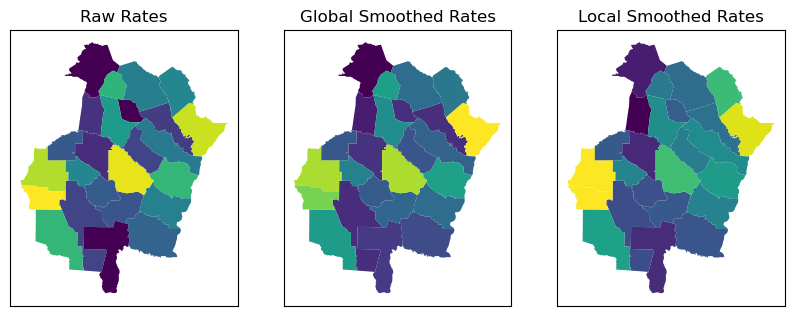

In [76]:
# plot new data
fig, ax = plt.subplots(1,3, figsize=(10, 5))

for i in range(3):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])



GA_vis.plot(ax=ax[0], column='rate')
ax[0].set_title('Raw Rates')

GA_vis.plot(ax=ax[1], column='Bayesrate')
ax[1].set_title('Global Smoothed Rates')

GA_vis.plot(ax=ax[2], column='localbayesrate')
ax[2].set_title('Local Smoothed Rates')

plt.show()

From the above plots, we can see that the local Bayes smoother does a better job of reducing noise in the rates while preserving information. We can more easily pinpoint areas of high/low rates as well as trends in spatial variability throughout the region. It is worth noting the 2 counties on the left (Coffee and Atkinson counties), which appear to have very high rates in the locally smoothed plot; while these counties' raw rates are indeed high, their inflated rates in the locally smoothed plot are likely due to edge effects, as they have fewer neighbors to borrow information from (and they are neighbors of each other, meaning the high rate of one influences the other). We can observe that this issue is largely controlled in the globally smoothed plot, which suffers less from edge effects. 

Overall, both smoothers are consistent with the probability plot, and convey the following information more clearly:
* Coffee, Atkinson, Chatham, and Wayne counties have the highest VLBW rates in the region
* There appears to be a North-South band of lower VLBW rates running from Emmanuel county to Charlton county
* VLBW rates are higher on average in the Eastern half of the region, with the exception of Coffee and Atkinson counties in the West